In [13]:
# Import required packages
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] ="false"


/tmp/ipykernel_1427348/4142949470.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(low),
/tmp/ipykernel_1427348/4142949470.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(high),


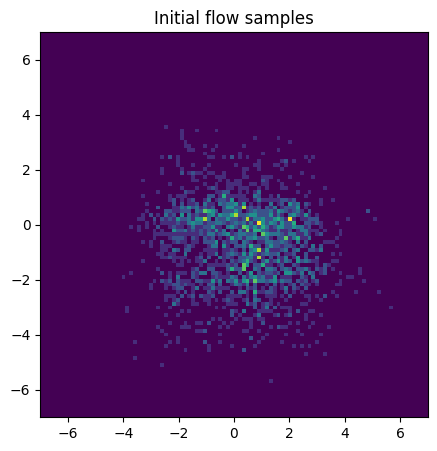

In [14]:

from matplotlib import pyplot as plt
import numpy as np
import zuko
import torch
ndim=2
bins = 16  # same as Zuko's `bins`
hidden = (64, 64)
n_transforms = 3
low = torch.tensor([-.0, -.0])
high = torch.tensor([1, 1.0])
# low = np.array([-3.0, -3.0])
# high = np.array([3, 3.0])
low = torch.tensor([-7.0, -7.0])
high = torch.tensor([7, 7.0])


class NormFlow():
    def __init__(self, low, high, ndim):
        bins = 8
        self.ndim = ndim
        self.device = "cuda"
        self.low = low.to(self.device)
        self.high = high.to(self.device)
        
        self.scale = 10.0
        maf = zuko.flows.MAF(
            features=self.ndim,
            context=0,
            univariate=zuko.transforms.MonotonicRQSTransform,
            shapes=[(bins,), (bins,), (bins - 1,)],
            hidden_features=(64, 64),
            transforms=3,
            
        )
        
        self.flow = zuko.flows.Flow(maf.transform.inv, maf.base).to(self.device)
    def normalize_samples(self, samples):
        """Normalize samples into standardized space"""

        if samples.ndim == 1:
            samples.reshape(1, -1)

        return ((samples - (self.low+self.high)/2.0  ) / (self.high - self.low)) * self.scale


    def denormalize_samples(self, samples):
        """Denormalize samples back in their true space"""
        samples = samples.to(self.device)
        if samples.ndim == 1:
            samples.reshape(1, -1)

        return (self.high - self.low) * samples / self.scale + (self.low+self.high)/2.0

    def log_prob(self, x):
        norm_x = self.normalize_samples(x.to(self.device))
        return self.flow().log_prob(norm_x.type(torch.FloatTensor).to(self.device))
    def rsample(self, sample_shape=torch.Size()):
         
        # Normalized Truncated Normal distribution in [0, 1]
        n_valids = 0
        n_samples = sample_shape[0]
        non_valid_mask = torch.ones((n_samples)).bool()
        samples = torch.zeros((n_samples, self.ndim)).type(torch.FloatTensor).to(self.device)
        n_iters = 0
        while n_valids < n_samples:
            if(n_iters>0):
                print("regenerating iter {}".format(str(n_iters)))        
            norm_samples, _ = self.flow().rsample_and_log_prob((non_valid_mask.int().sum(),))
            norm_samples = norm_samples.type(torch.FloatTensor).to(self.device)
            samples[non_valid_mask] = self.denormalize_samples(norm_samples).to(samples.dtype)
            mask_low = torch.greater_equal(samples, self.low.view(1,-1))
            mask_high = torch.less_equal(samples, self.high.view(1,-1))
            per_sample_mask_with_dim = torch.cat([mask_low, mask_high], dim=-1) # (n_samples, 2*ndim)
            per_sample_mask = torch.all(per_sample_mask_with_dim, dim=-1)
            non_valid_mask = ~per_sample_mask
            n_valids = per_sample_mask.int().sum()
            n_iters += 1
        if n_iters >= 10:
            print('WARNING! Sampling through the truncated normal took {n_iters} >= 10 iterations for resampling.')
        
        return samples
        
    def get_params(self):
        return self.flow.parameters()
# Sampling:
flow = NormFlow(
    torch.tensor(low),
    torch.tensor(high),
    ndim=len(low)
)
optimizer= torch.optim.Adam(flow.get_params(), lr=1e-3)
contexts = flow.rsample([2048]).detach().cpu().numpy()
plt.figure(figsize=(5, 5))
plt.hist2d(contexts[:, 0], contexts[:, 1], bins=100, range=[[low[0], high[0]], [low[1], high[1]]])
plt.title("Initial flow samples")
plt.show()


/tmp/ipykernel_1427348/1049526307.py:152: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  pdf_values = np.exp(pdf_values)


regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1
regenerating iter 1


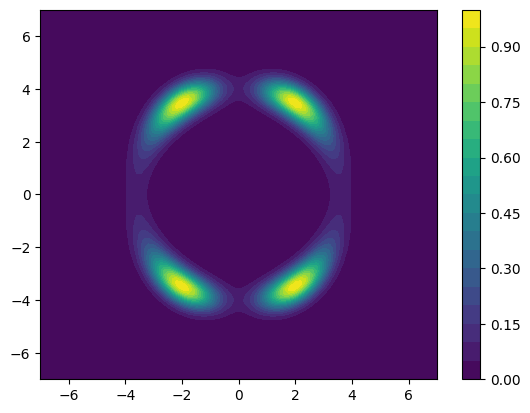

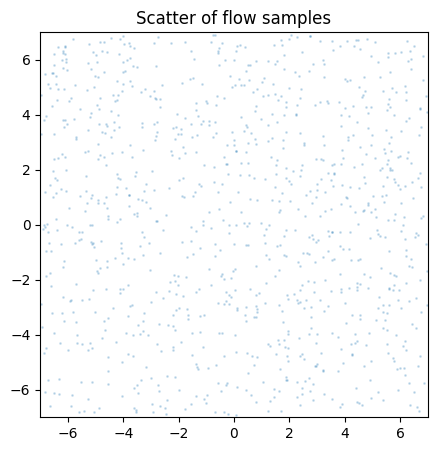

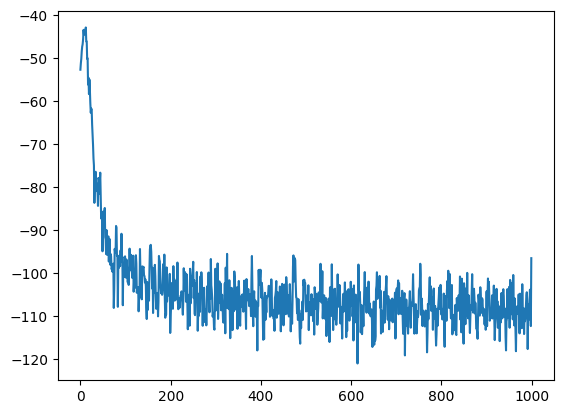

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import torch
from torch.distributions import MultivariateNormal, Uniform
def target1(x):
    device = x.device
    # Mixture of two Gaussians
    mean1 = torch.tensor([1.0, 0.4], device=device)
    cov1 = 0.3 * torch.tensor([[1.0, 0.3], [0.3, 1.0]], device=device)
    dist1 = MultivariateNormal(mean1, cov1)

    # Gaussian 2
    mean2 = torch.tensor([-1.0, -0.4], device=device)
    cov2 = 0.1 * torch.tensor([[1.0, -0.3], [-0.3, 1.0]], device=device)
    dist2 = MultivariateNormal(mean2, cov2)

    # We use .exp() because log_prob returns the natural log of the density
    pdf1 = dist1.log_prob(x).exp()
    pdf2 = dist2.log_prob(x).exp()
    return torch.log(0.4 * pdf1 + 0.6 * pdf2)
def target2(z):
    split_idx = z.shape[1]//2
    z1 = z[:, :split_idx]
    z2 = z[:, split_idx:]
    # z1, z2 = torch.split(z, 2, dim=-1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)

    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)

    return -u
def reward_corner(contexts, target=torch.tensor([0.3, 0.7]), sigma=0.12, noise_std=0.2, key=None):
    # reward in [0,1], peaked near target
    device = contexts.device
    diff = contexts - target[None, :]
    r = torch.exp(-0.5 * torch.sum((diff / sigma) ** 2, dim=-1))
    if key is not None:
        r = torch.clip(r + noise_std * torch.random.randn(r.shape, device=device), 0.0, 1.0)
    log_r =  torch.log(r + 1e-10)
    return torch.nn.functional.log_softmax(log_r)
beta = 10
def target3(z):
    m=3
    r0=0.65
    sr=0.12
    # X, Y = torch.split(z, 2, dim=-1)
    split_idx = z.shape[1]//2
    X = z[:, :split_idx]
    Y = z[:, split_idx:]
    x = 2.0 * (X - 0.5)
    y = 2.0 * (Y - 0.5)
    r = torch.hypot(x, y)
    theta = torch.arctan2(y, x)

    ring = torch.exp(-0.5 * ((r - r0) / sr) ** 2)
    petals = torch.cos(m * theta)
    U = torch.tanh(1.6 * (ring * petals))  # bounded in (-1, 1)
    log_unnorm = -beta * U.squeeze() 
    regularization_weight = .01
    log_prior = -0.5 * regularization_weight * torch.sum(z**2, dim=-1)

    # --- 3. Combine ---
    return torch.nn.functional.log_softmax(log_unnorm) #+ log_prior
volume = torch.prod(high - low)
N = 2 **10

def run_toy_corner(model, flow_opt):
    x, y = np.meshgrid(np.linspace(low[0], high[0], 100), np.linspace(low[1], high[1], 100))
    grid = np.c_[x.ravel(), y.ravel()]
    # pdf_values = reward_corner(grid)
    # pdf_values = target1(torch.from_numpy(grid)).detach().cpu().numpy()
    # pdf_values = target2(torch.from_numpy(grid)).detach().cpu().numpy()
    pdf_values = target2(torch.from_numpy(grid)).detach().cpu().numpy()
    pdf_values = np.exp(pdf_values)
    pdf_values = np.reshape(pdf_values, x.shape)
    T = 1000
    snap_iters = [0, 1, 2, 5, 10, 15, 24] + list(range(30, T, 10))
    # snap_iters = []
    gif_frames = [] 
    loss_hist = []
    for t in range(T):
        flow_opt.zero_grad()
        _low = low.to(device=model.device)
        _high = high.to(device=model.device)
        # contexts = torch.rand((N,2), device=model.device) * (_high-_low) + _low
        # logq  = model.log_prob(contexts)
        contexts = model.rsample([N])
        logq  = model.log_prob(contexts)
        # logq = torch.clamp(logq, min=1e-6, max=1e6)
        # contexts, logq = model.sample((N,), rng=kc)
        # logp  = reward_corner(contexts, key=kr)
        # logp = target1(contexts).detach().to(logq.dtype)
        logp_nograd = target2(contexts).detach().to(logq.dtype)
        logp = target2(contexts)
        # value_loss = -volume * torch.mean(logq * torch.exp(logq) * logp_nograd)
        value_loss = - torch.mean(logq * logp_nograd)
        # kl_loss = volume * torch.mean(logq * torch.exp(logq))
        kl_loss = torch.mean(logq)
        # loss =  torch.mean(logq-logp)
        loss= value_loss + kl_loss
        loss.backward()
        flow_opt.step()
        loss_hist.append(loss.item())
        if t in snap_iters:
            fig, (ax_reward, ax_NF) = plt.subplots(1, 2, figsize=(10, 4))
            ctf = ax_reward.contourf(x, y, pdf_values, levels=20)
            ax_reward.set_title("reward_corner landscape")
            ax_reward.set_xlabel("context dim 1")
            ax_reward.set_ylabel("context dim 2")
            fig.colorbar(ctf, ax=ax_reward, label="reward")
            z= model.rsample([2**20]).detach().cpu().numpy()  # Sample 1000 points
            ax_NF.hist2d(z[:, 0].flatten(), z[:, 1].flatten(), (100, 100), #range=[[-3, 3], [-3, 3]])
                    range=[[low[0], high[0]], [low[1], high[1]]])
            ax_NF.set_title(f"NF(Neural Spline) training distribution (iter {t})")
            fig.tight_layout()
            fig.canvas.draw()
            frame = np.asarray(fig.canvas.buffer_rgba())[..., :3]
            gif_frames.append(frame)
            plt.close(fig)
            


    if gif_frames:
        imageio.mimsave("zuko training.gif", gif_frames, fps=4)
        print("Saved GIF to zuko training.gif")
    x= model.rsample([1024]).detach().cpu().numpy()
    np.save(f"ns1_samples_beta={beta}.npy", x)
    # 1) Raw scatter plot (no binning)
    plt.figure(figsize=(5, 5))
    plt.scatter(x[:, 0], x[:, 1], s=1, alpha=0.2)
    plt.xlim(low[0], high[0])
    plt.ylim(low[1], high[1])
    plt.title("Scatter of flow samples")
    plt.savefig(f"NS1_image_beta={beta}.png")
    plt.show()
    
    # 2) Coarse 2D histogram to kill striping
    # plt.figure(figsize=(5, 5))
    # plt.hist2d(x[:, 0], x[:, 1], bins=40, range=[[low[0], high[0]], [low[1], high[1]]])
    # plt.title("Flow samples hist2d, coarse bins")
    # plt.show()
    loss_plot = np.array(loss_hist)
    plt.plot(loss_plot)
x, y = np.meshgrid(np.linspace(low[0], high[0], 100), np.linspace(low[1], high[1], 100))
grid = np.c_[x.ravel(), y.ravel()]
# pdf_values = reward_corner(grid)
# pdf_values = target1(torch.from_numpy(grid))
# pdf_values = target2(torch.from_numpy(grid))
pdf_values = target2(torch.from_numpy(grid))
pdf_values = np.exp(pdf_values)
pdf_values = np.reshape(pdf_values, x.shape)
fig = plt.figure()
ctf = plt.contourf(x, y, pdf_values, levels=20, cmap='viridis')
cbar = fig.colorbar(ctf)
# ax = render_flow_pdf_2d_subplots(
#                 log_prob_fn=lambda x : dist_bijx.log_density(x=x),
#                 low=low,
#                 high=high,
#             )
run_toy_corner(flow, optimizer)
